# 第6回課題
前処理と特徴量選択により，SVM の最初のスコアよりも1割程度良いテストスコアを出してください．
ちょこっといじった程度では，線形回帰はスコアが変わらなかったので，参考程度に使ってください
feature_names から対象の変数を削除する．feature_names.remove()などを駆使することで容易に扱う特徴量を変更できます．

### 必須事項
- 前処理：正規化，標準化，外れ値の排除など
- 特徴量選択: 検証は必須．増やす・減らす・変えないの結果は自由
- テストスコアの向上: mse で 0.41 くらいは出ると思います

### 自由事項
- 指標の変更
- ハイパーパラメータの変更（モデルの変更は想定してません）

### 余談
特徴量選択で正解を用意するのは，やはり難しいなと解答を作る時に感じました．解答の方は最低限の考察と検証をしていますが，4時間かかりました( ;∀;)

## 注意事項
特徴量の分析時に分割したデータを使ってない時点でせこいというか，おかしいです．ここでは無視していますが，本来はできません．

# 総括
一応、本日の総括を再度書いておくと
- 特徴量選択には正解はないという前提の下で、明らかに弾けるものを用意しました。
 * PH2（ワインは酸味で語られるので）
 * color intensity（色の強さとしましたが，あまりにも無相関）※実際にはあり得ないわけではないですが，予測に使う理由もないと思います．
 * fixed acidity （負の値を取らないはずなので）
- どちらでも良い，あるいは，選択がそもそもできないものとして
　alcohol, alcohol2 があります（あまりに微小なノイズだったので）．

　※口頭でも言いましたが，正解の方は小数点第2以下がないので見分けることは一応できました（作者の意図を読めば）．

- 元々存在する特徴量について，使うか使わないか選択することはできますが
　これらについては正解があるかどうかはわかりません．
　元々ある程度関係のあるものしか残っていないというの理由としてあります．
- 外部の特徴量についても，このデータでは利用することは不可能です．


また，今回の演習の悪い所が1つあって
元々あった特徴量を正しく選択できないと，ノイズを含んだ特徴量でテストすることになるので
それぞれの結果の比較について，あれこれ言うことができないです．

繰り返しになりますが，
今回与えられた条件下（ドメイン知識，モデル）では
誰にも正解がわからない問題だったので，時間を割く意味はそこまでないです．
逆に言うと，正解が出せる条件下で問題を解きましょうという感じです．

裏のテーマは「考えること」と「会話すること」でした．

In [ ]:
# warning 無視しないと エラー文に含まれるディレクトリ構造が github 上に上がる可能性があります
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=DeprecationWarning)
# すべての warning を無視する場合，これでも解決しない場合は該当の cell を再実行すると消えるはずです．
# import warnings
# warnings.filterwarnings('ignore')
# warnings.simplefilter('ignore')

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import random
import seaborn as sns
from sklearn.linear_model import Ridge
from sklearn.svm import SVC, SVR
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import mean_squared_error, accuracy_score, make_scorer

In [ ]:
random.seed(0)
np.random.seed(0)

# 本来の特徴量
For more information, read [Cortez et al., 2009].
Input variables (based on physicochemical tests):

- fixed acidity
- volatile acidity
- citric acid
- residual sugar
- chlorides
- free sulfur dioxide
- total sulfur dioxide
- density
- pH
- sulphates
- alcohol

Output variable (based on sensory data):
- quality (score between 0 and 10)

In [ ]:
wine_quality_df = pd.read_csv("winequality-red.csv",delimiter=";")
print(wine_quality_df.shape)
wine_quality_df.head()

(1599, 12)


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [ ]:
wine_quality_df.dtypes

fixed acidity           float64
volatile acidity        float64
citric acid             float64
residual sugar          float64
chlorides               float64
free sulfur dioxide     float64
total sulfur dioxide    float64
density                 float64
pH                      float64
sulphates               float64
alcohol                 float64
quality                   int64
dtype: object

In [ ]:
wine_quality_df.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000
mean,8.319637,0.527821,0.270976,2.538806,0.087467,15.874922,46.467792,0.996747,3.311113,0.658149,10.422983,5.636023
std,1.741096,0.179060,0.194801,1.409928,0.047065,10.460157,32.895324,0.001887,0.154386,0.169507,1.065668,0.807569
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.740000,0.330000,8.400000,3.000000
25%,7.100000,0.390000,0.090000,1.900000,0.070000,7.000000,22.000000,0.995600,3.210000,0.550000,9.500000,5.000000
50%,7.900000,0.520000,0.260000,2.200000,0.079000,14.000000,38.000000,0.996750,3.310000,0.620000,10.200000,6.000000
75%,9.200000,0.640000,0.420000,2.600000,0.090000,21.000000,62.000000,0.997835,3.400000,0.730000,11.100000,6.000000
max,15.900000,1.580000,1.000000,15.500000,0.611000,72.000000,289.000000,1.003690,4.010000,2.000000,14.900000,8.000000


# 偽物の特徴量を作る
性格の悪さがにじみ出る。。。
- ただのノイズ
- pH を反対にする
- 大きいノイズを混ぜた特徴量をつくる
- 小さめのノイズを混ぜた特徴量をつくる（区別の難しい一方，元の特徴に対して相関性の高い特徴）

In [ ]:
x = np.random.randn(wine_quality_df.shape[0])
wine_quality_df["color intensity"] = (x - np.min(x))/(np.max(x) - np.min(x))

In [ ]:
wine_quality_df["pH1"] = wine_quality_df["pH"]
wine_quality_df["pH2"] = 14 - wine_quality_df["pH"]
del wine_quality_df["pH"]

In [ ]:
big_noise = 10 * np.random.randn(wine_quality_df.shape[0])
wine_quality_df["tmp"] = wine_quality_df["fixed acidity"]
wine_quality_df["fixed acidity"] = wine_quality_df["tmp"] + big_noise
wine_quality_df["fixed acidity2"] = wine_quality_df["tmp"]
del wine_quality_df["tmp"]

In [ ]:
small_noise = 0.3 * np.random.randn(wine_quality_df.shape[0])
wine_quality_df["tmp"] = wine_quality_df["alcohol"]
wine_quality_df["alcohol"] = wine_quality_df["tmp"]
wine_quality_df["alcohol2"] = wine_quality_df["tmp"] + small_noise
del wine_quality_df["tmp"]

In [ ]:
# 列の並び替え
feature_names = sorted(np.copy(wine_quality_df.columns))
wine_quality_df = wine_quality_df[feature_names]

In [ ]:
wine_quality_df.describe()

,alcohol,alcohol2,chlorides,citric acid,color intensity,density,fixed acidity,fixed acidity2,free sulfur dioxide,pH1,pH2,quality,residual sugar,sulphates,total sulfur dioxide,volatile acidity
count,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000
mean,10.422983,10.422622,0.087467,0.270976,0.487514,0.996747,7.877670,8.319637,15.874922,3.311113,10.688887,5.636023,2.538806,0.658149,46.467792,0.527821
std,1.065668,1.110855,0.047065,0.194801,0.157708,0.001887,9.858849,1.741096,10.460157,0.154386,0.154386,0.807569,1.409928,0.169507,32.895324,0.179060
min,8.400000,8.232370,0.012000,0.000000,0.000000,0.990070,-24.368566,4.600000,1.000000,2.740000,9.990000,3.000000,0.900000,0.330000,6.000000,0.120000
25%,9.500000,9.570963,0.070000,0.090000,0.380724,0.995600,0.892154,7.100000,7.000000,3.210000,10.600000,5.000000,1.900000,0.550000,22.000000,0.390000
50%,10.200000,10.191857,0.079000,0.260000,0.486193,0.996750,7.684445,7.900000,14.000000,3.310000,10.690000,6.000000,2.200000,0.620000,38.000000,0.520000
75%,11.100000,11.140724,0.090000,0.420000,0.590375,0.997835,14.510449,9.200000,21.000000,3.400000,10.790000,6.000000,2.600000,0.730000,62.000000,0.640000
max,14.900000,14.554818,0.611000,1.000000,1.000000,1.003690,44.616602,15.900000,72.000000,4.010000,11.260000,8.000000,15.500000,2.000000,289.000000,1.580000


In [ ]:
wine_quality_df.to_csv("wine_quality_noise.csv", index=False)

In [ ]:
feature_names = list(np.copy(wine_quality_df.columns))
feature_names.remove("quality")

In [ ]:
X_train, X_test, y_train, y_test = \
    train_test_split(wine_quality_df[feature_names], wine_quality_df["quality"], 
                     test_size=0.3, random_state=0)
X_train.shape, X_test.shape

((1119, 15), (480, 15))

## 注意
ここで，test score まで同時に出してしまっているんですが，1つの関数で実行してしまう方が楽だったという理由だけで，これらは分けた方が良いです．
パラメータや特徴量について考えるときには，CV だけで調整すべきです

In [ ]:
kfold = KFold(n_splits=5, random_state=0)
def cross_validation(model, test=True, method="reg"):
    global X_train, X_test, y_train, y_test, feature_names
    evaluation_method = mean_squared_error if method == "reg" else accuracy_score
    scores = cross_val_score(model, X_train[feature_names], y_train, cv=kfold, 
                             scoring=make_scorer(evaluation_method))
    # 各分割におけるスコア
    print('Cross-Validation scores: {}'.format(scores))
    # スコアの平均値
    print('Average score: {}'.format(np.mean(scores)))
    if test:
        model.fit(X_train[feature_names], y_train)
        pred = model.predict(X_test[feature_names])
        print('Test score: {}'.format(evaluation_method(y_test, pred)))

# モデルによる予測

In [ ]:
linear_reg = Ridge(random_state=0)
cross_validation(linear_reg)

Cross-Validation scores: [0.48873469 0.4972921  0.43186159 0.42859749 0.36981067]
Average score: 0.4432593072010188
Test score: 0.40137607230241273


In [ ]:
svm_reg = SVR(kernel="rbf")
cross_validation(svm_reg)

Cross-Validation scores: [0.63541597 0.68327096 0.58850596 0.59033828 0.50432621]
Average score: 0.6003714763595539
Test score: 0.554464275505919


In [ ]:
svm_clf = SVC(kernel="rbf", random_state=0)
cross_validation(svm_clf, method="clf")

Cross-Validation scores: [0.52232143 0.44642857 0.50446429 0.44196429 0.47085202]
Average score: 0.47720611787315814
Test score: 0.48125


# 以降にコードを追加

# 解答例

In [ ]:
# 追加 import
from sklearn.preprocessing import MinMaxScaler, StandardScaler

まず，これを改造することにします．本当は CV の方を変えたいんですが，sklearn の内部をいじるのは面倒なので，test の結果をもう少し細かく見れるようにしましょう

In [ ]:
def cross_validation(model, test=True, method="reg"):
    global X_train, X_test, y_train, y_test, feature_names
    evaluation_method = mean_squared_error if method == "reg" else accuracy_score
    scores = cross_val_score(model, X_train[feature_names], y_train, cv=kfold, 
                             scoring=make_scorer(evaluation_method))
    # 各分割におけるスコア
    print('Cross-Validation scores: {}'.format(scores))
    # スコアの平均値
    print('Average score: {}'.format(np.mean(scores)))
    model.fit(X_train[feature_names], y_train)
    pred = model.predict(X_train[feature_names])
    for i in np.sort(np.unique(y_train)):
        print('Train score in the case of quality {}: size {}, score {}'.format(
                i, len(y_train[y_train==i]), evaluation_method(y_train[y_train==i], pred[y_train==i])))
            
    if test:
        pred = model.predict(X_test[feature_names])
        print('Test score: {}'.format(evaluation_method(y_test, pred)))
        pred = pred.astype(np.int)
        for i in np.sort(np.unique(y_test)):
            print('Test score in the case of quality {}: size {}, score {}'.format(
                    i, len(y_test[y_test==i]), evaluation_method(y_test[y_test==i], pred[y_test==i])))

In [ ]:
#linear_reg = Ridge(random_state=0)
cross_validation(linear_reg, False)
#svm_reg = SVR(kernel="rbf")
cross_validation(svm_reg, False)
#svm_clf = SVC(kernel="rbf", random_state=0)
cross_validation(svm_clf, False, method="clf")

Cross-Validation scores: [0.48873469 0.4972921  0.43186159 0.42859749 0.36981067]
Average score: 0.4432593072010188
Train score in the case of quality 3: size 7, score 4.059872510649852
Train score in the case of quality 4: size 38, score 1.9046069943213737
Train score in the case of quality 5: size 473, score 0.2765508027031293
Train score in the case of quality 6: size 434, score 0.23528042108086916
Train score in the case of quality 7: size 154, score 0.7273913681982577
Train score in the case of quality 8: size 13, score 2.46164222869628
Cross-Validation scores: [0.63541597 0.68327096 0.58850596 0.59033828 0.50432621]
Average score: 0.6003714763595539
Train score in the case of quality 3: size 7, score 4.241759319782245
Train score in the case of quality 4: size 38, score 0.8601696168084246
Train score in the case of quality 5: size 473, score 0.05122523757854536
Train score in the case of quality 6: size 434, score 0.03324281204790991
Train score in the case of quality 7: size 154

実際には予測するクラスに偏りがあり，また，サンプル数の少ないクラスほど誤差が大きくなっていることがわかります．
テストは不可能としているので，False にしてます．
また，今回のテストでは，学習対象のすべてのデータを用いて再学習しています（CVでモデルや特徴の良さは確認しているので）．

特徴量について調査
- fixed acidity1,2　固定酸度
- volatile acidity　揮発性酸
- citric acid　クエン酸
- residual sugar　残糖
- chlorides　塩素
- free sulfur dioxide　遊離二酸化硫黄
- total sulfur dioxide　全二酸化硫黄
- density　濃度
- pH1,2
- color intensity 色の濃さ
- sulphates　硫酸塩
- alcohol1,2　アルコール

Output variable (based on sensory data):
- quality (score between 0 and 10)

酸に関連する成分が多いなと思いました．もう少し後で細かく調べることにして相関を見ます

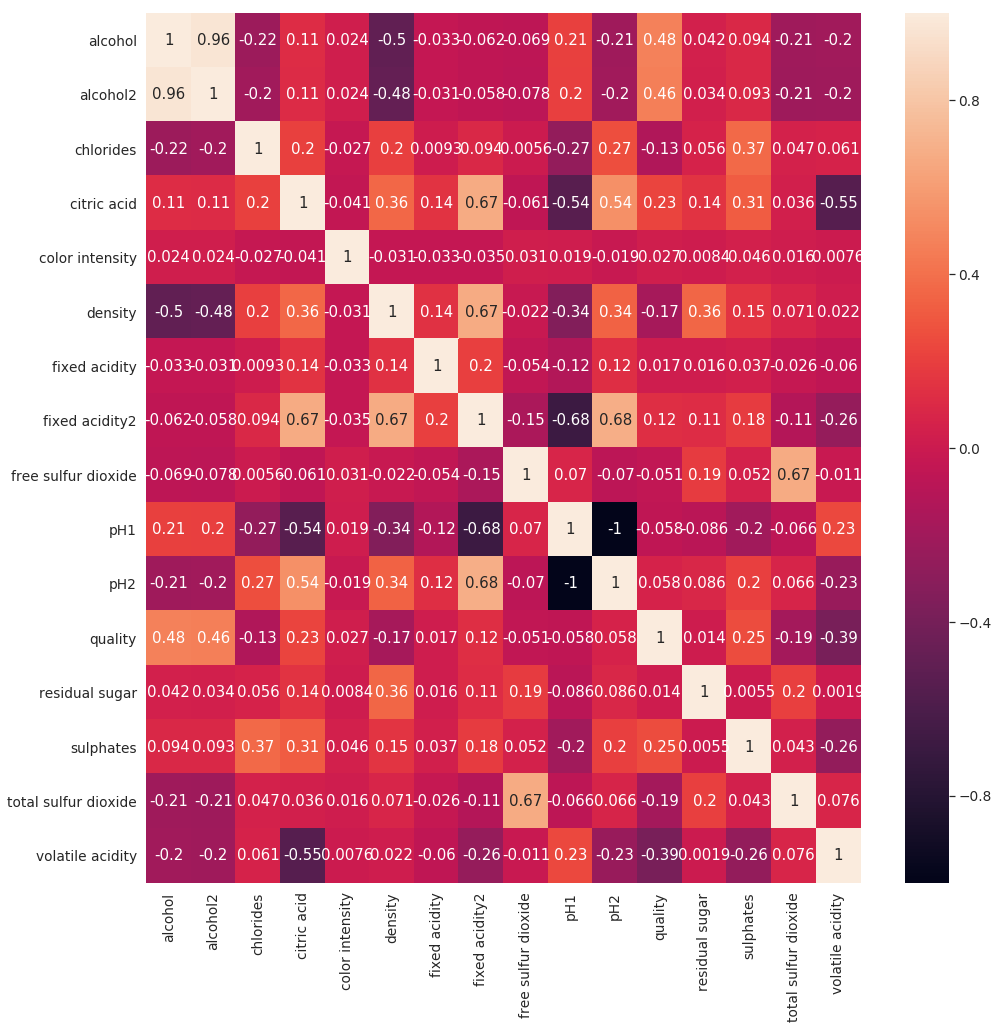

In [ ]:
plt.figure(figsize=(16, 16))
sns.set(font_scale=1.25)
sns.heatmap(wine_quality_df.corr(), annot = True)

今回は要らない変数も取り除く必要がありますが，fixed acidity はとりあえず不味そうです．
また，pH1, pH2 は各特長量に対して同じ相関を取っていて，どちらを扱っても良さそうです．
そして，alcoholのどっちか絶対削除してやるぞ( ;∀;)

<Figure size 1152x1152 with 0 Axes>

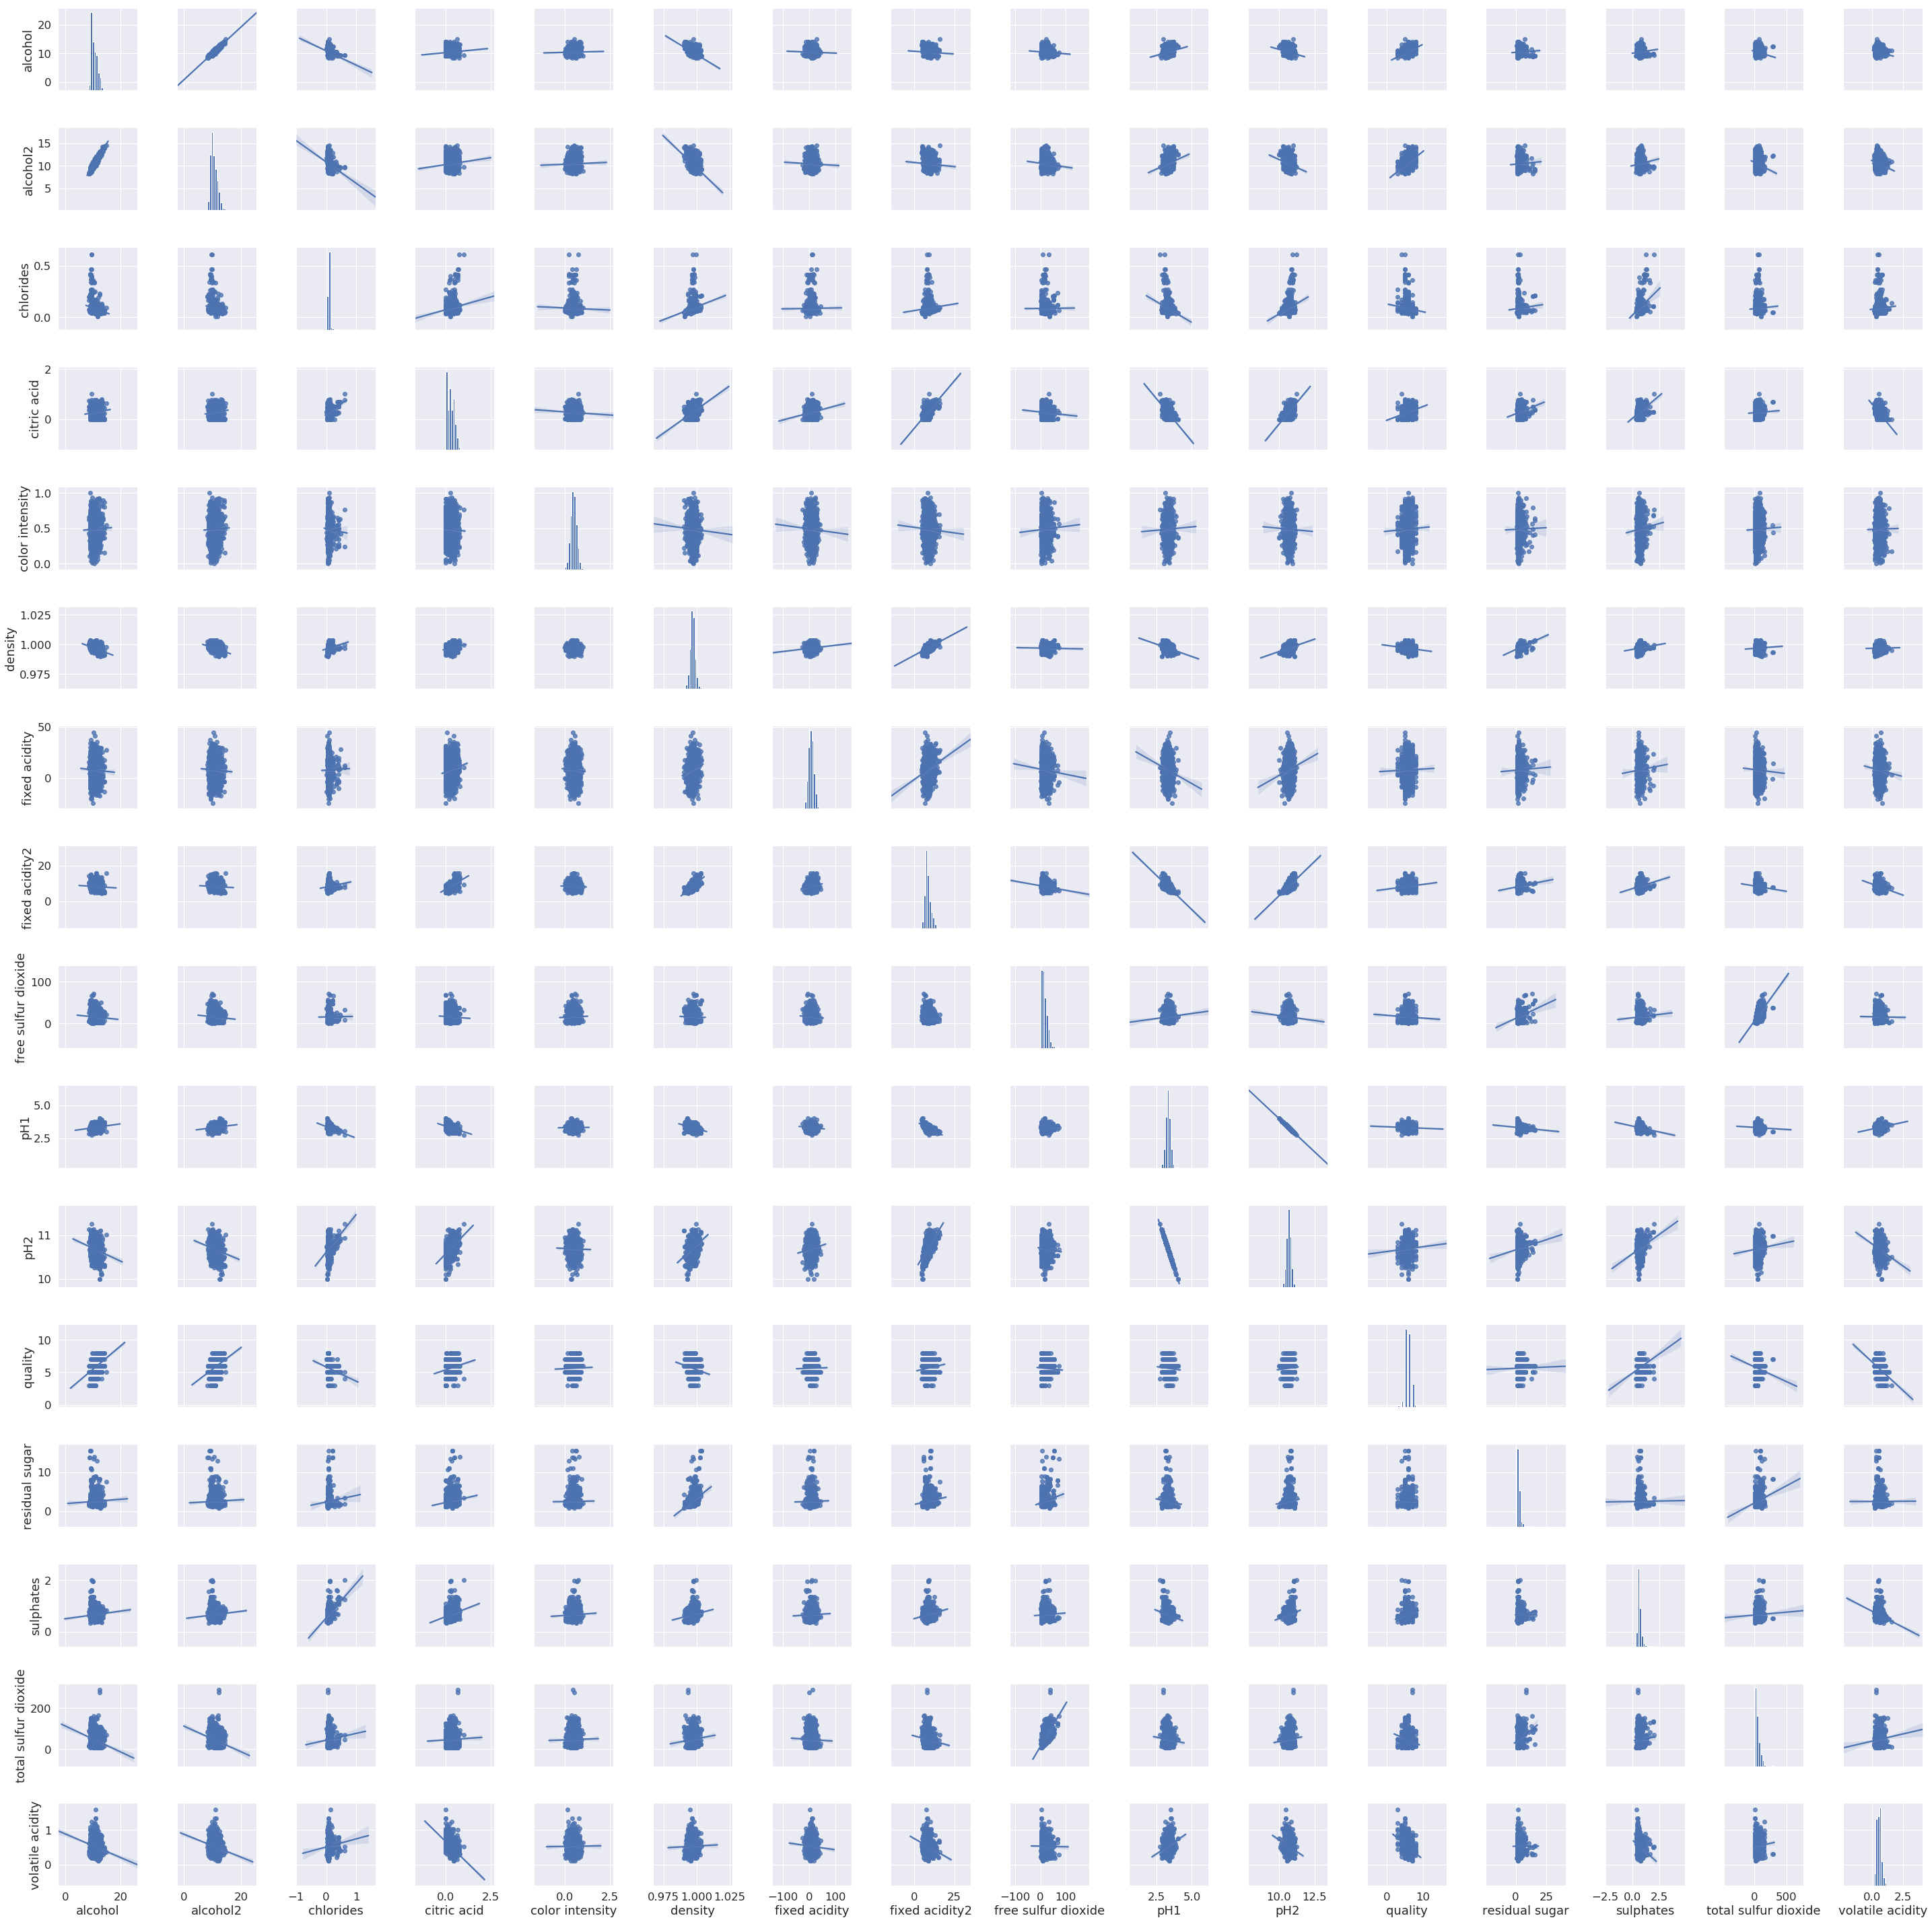

In [ ]:
plt.figure(figsize=(16, 16))
sns.set(font_scale=1.5)
sns.pairplot(wine_quality_df, kind="reg")

ただし，この時点で fixed acidity が使えないことは明らかだったりします．
というのも，describe した時，あるいは図においても fixed acidity がマイナスになる例が存在しますが
そもそも fixed acidity は負の値を取らないはずで，相関的にも低いからです．
という訳で，この時点で取り除きます．

小さすぎるので，もう少し個別に出す方が明らかにいいと思います．

In [ ]:
feature_names.remove("fixed acidity")

In [ ]:
wine_quality_df.head()

,alcohol,alcohol2,chlorides,citric acid,color intensity,density,fixed acidity,fixed acidity2,free sulfur dioxide,pH1,pH2,quality,residual sugar,sulphates,total sulfur dioxide,volatile acidity
0,9.4,9.439316,0.076,0.00,0.773702,0.9978,2.040854,7.4,11.0,3.51,10.49,5,1.9,0.56,34.0,0.70
1,9.8,9.536271,0.098,0.00,0.554324,0.9968,12.107711,7.8,25.0,3.20,10.80,5,2.6,0.68,67.0,0.88
2,9.8,9.399997,0.092,0.04,0.647387,0.9970,6.301084,7.8,15.0,3.26,10.74,5,2.3,0.65,54.0,0.76
3,9.8,9.910335,0.075,0.56,0.850400,0.9980,1.139631,11.2,17.0,3.16,10.84,6,1.9,0.58,60.0,0.28
4,9.4,8.983530,0.076,0.00,0.790350,0.9978,-0.815498,7.4,11.0,3.51,10.49,5,1.9,0.56,34.0,0.70


精度を出すために，一番簡単なシナリオは特徴量の正規化あるいは標準化によって十分な精度が出ることなので
ちょっと見ていきます．

In [ ]:
min_max_scaler = MinMaxScaler()
min_max_scaler.fit(X_train[feature_names])

MinMaxScaler(copy=True, feature_range=(0, 1))

In [ ]:
X_train[feature_names] = min_max_scaler.transform(X_train[feature_names])
X_test[feature_names] = min_max_scaler.transform(X_test[feature_names])

In [ ]:
cross_validation(linear_reg,False)
cross_validation(svm_reg, False)
cross_validation(svm_clf, False, method="clf")

Cross-Validation scores: [0.48785246 0.48902908 0.4327103  0.42970768 0.36331343]
Average score: 0.440522589529035
Train score in the case of quality 3: size 7, score 4.078043090023922
Train score in the case of quality 4: size 38, score 1.9217871868055745
Train score in the case of quality 5: size 473, score 0.27285833838440954
Train score in the case of quality 6: size 434, score 0.23364224871867298
Train score in the case of quality 7: size 154, score 0.735677370693402
Train score in the case of quality 8: size 13, score 2.4808925754363353
Cross-Validation scores: [0.48031325 0.51075555 0.43657073 0.44309081 0.37320645]
Average score: 0.4487873589460992
Train score in the case of quality 3: size 7, score 4.551261096025485
Train score in the case of quality 4: size 38, score 1.9254682130919079
Train score in the case of quality 5: size 473, score 0.2252760858349988
Train score in the case of quality 6: size 434, score 0.2759912966751732
Train score in the case of quality 7: size 154,

これだけでも SVM はかなり良くなりました．線形回帰は変わっていませんね

（分散を基準としたものを利用しているので）相関は変わりませんが，関係は異なって見えます

<Figure size 1152x1152 with 0 Axes>

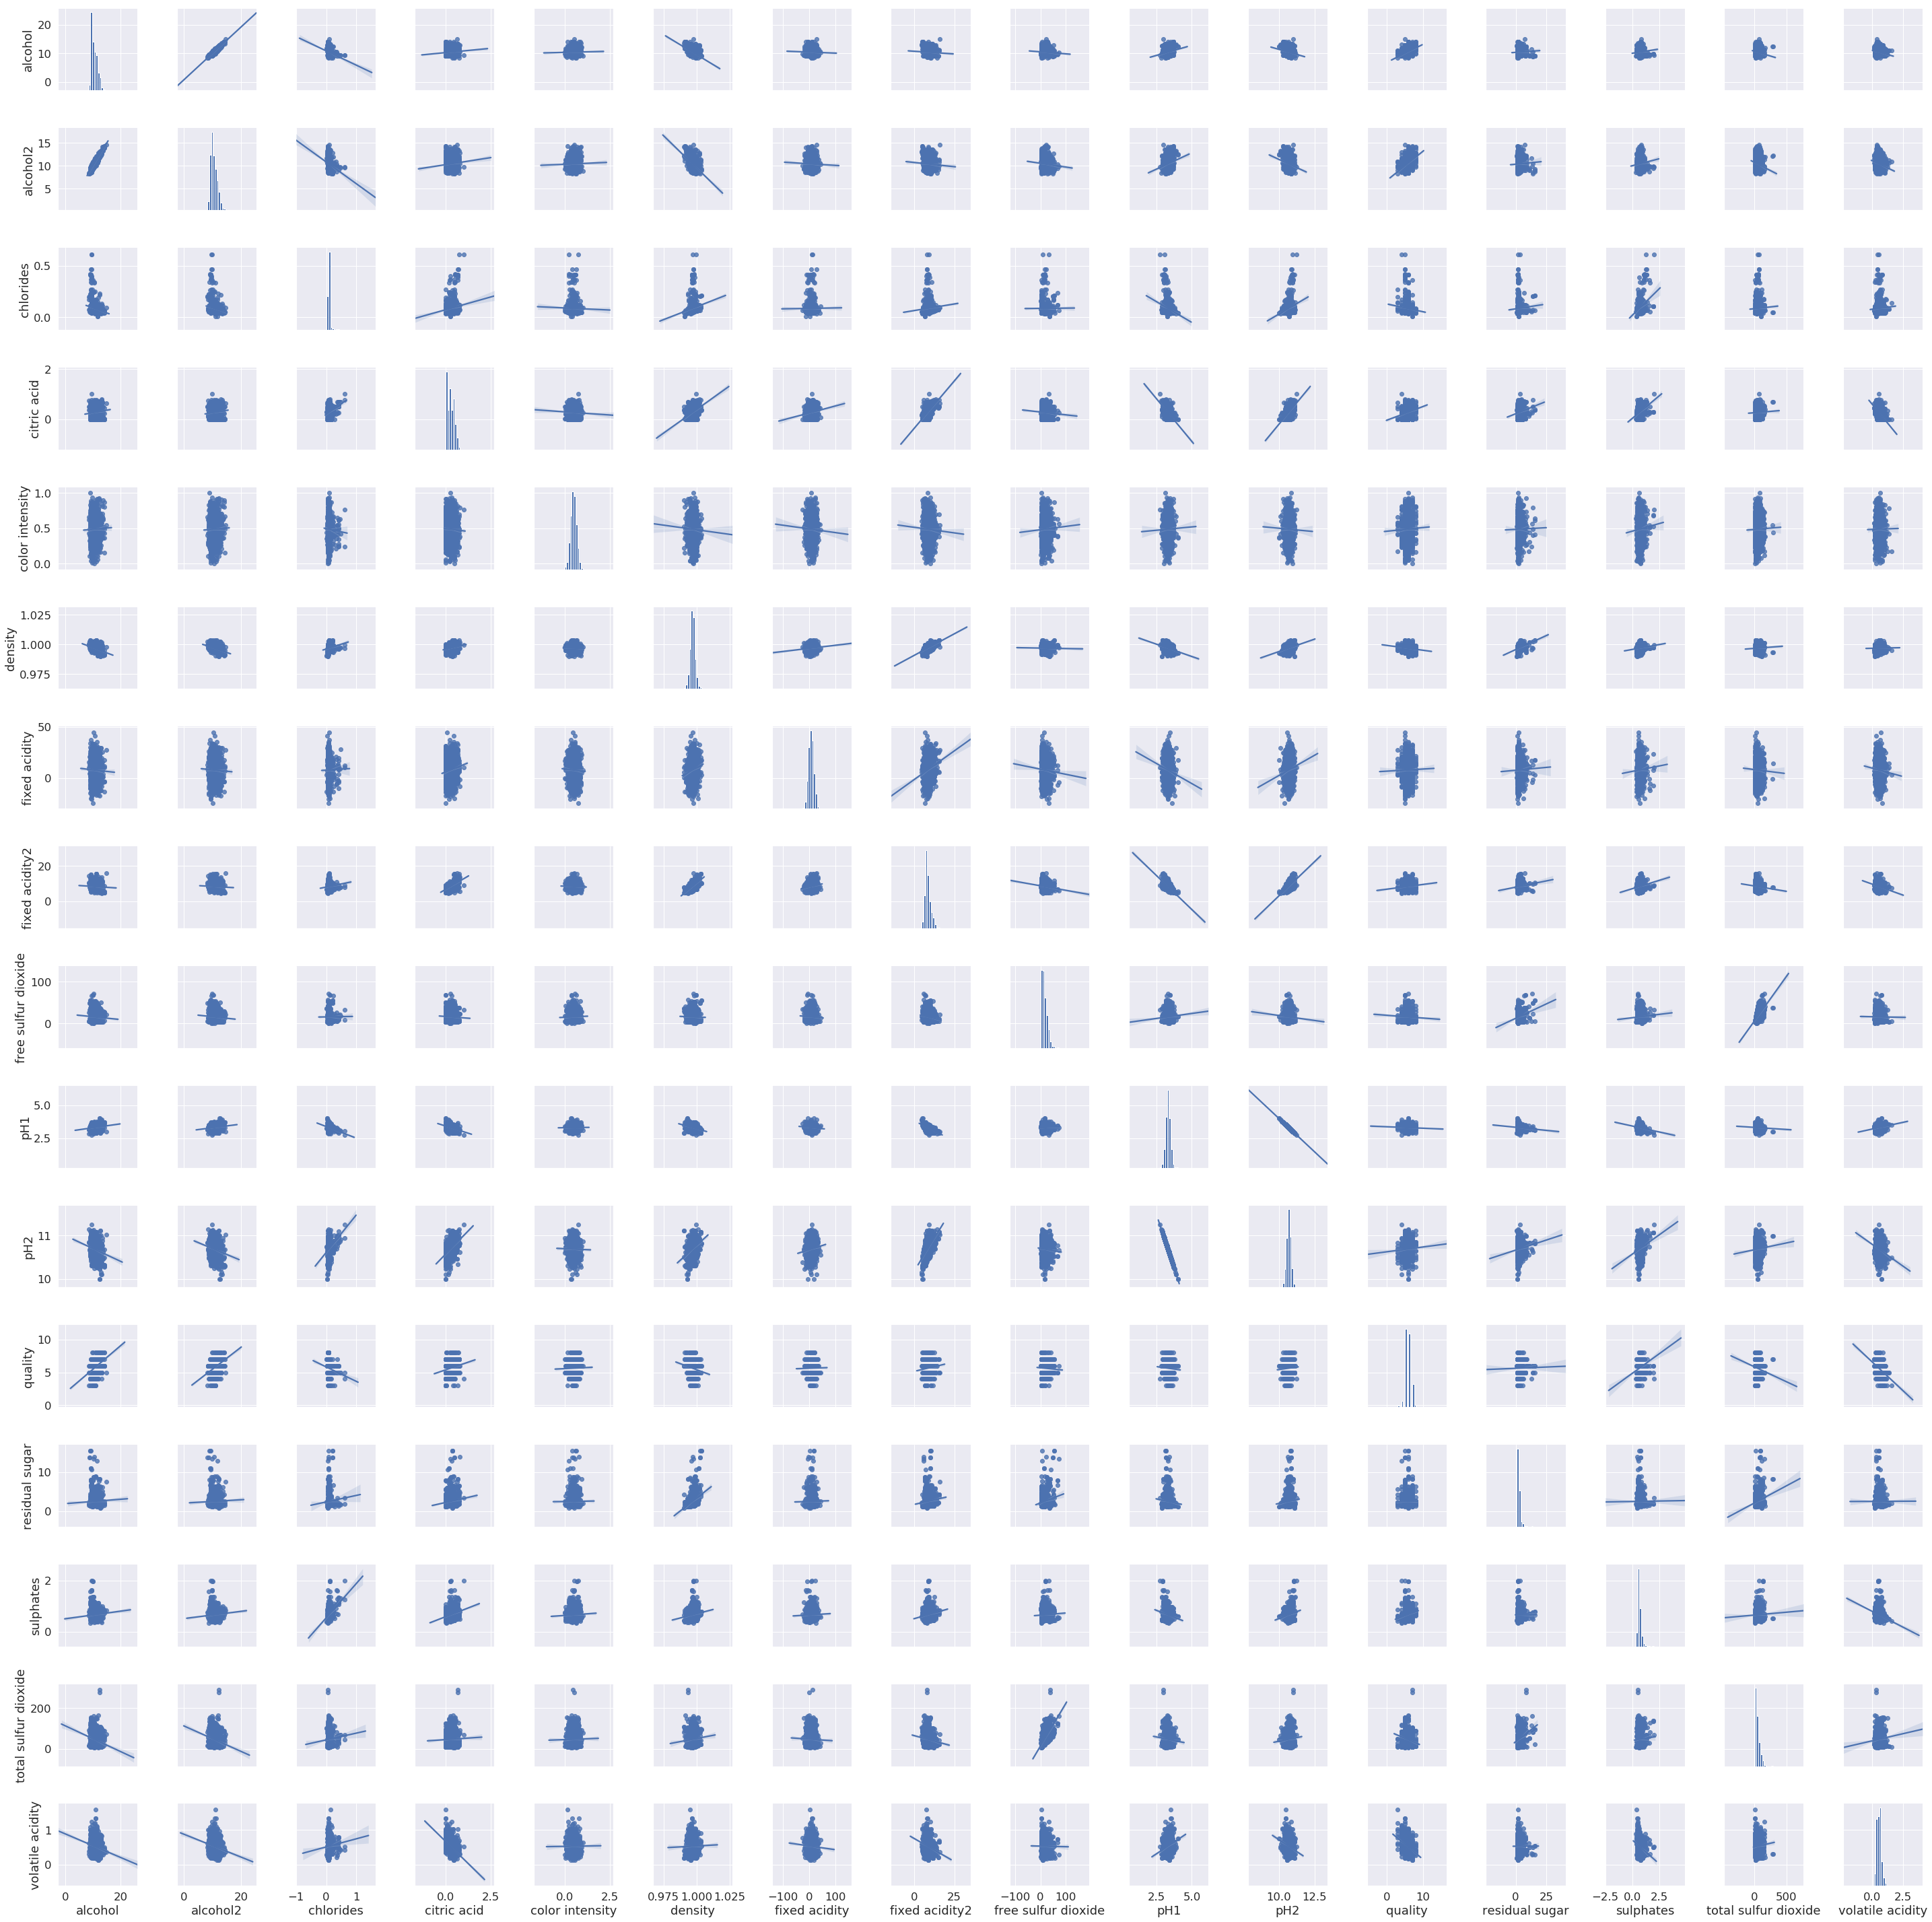

In [ ]:
plt.figure(figsize=(16, 16))
sns.set(font_scale=1.5)
sns.pairplot(wine_quality_df, kind="reg")

In [ ]:
standard_scaler = StandardScaler()
#wine_quality_df = pd.read_csv("winequality-red.csv",delimiter=";")
standard_scaler.fit(X_train[feature_names])
X_train[feature_names] = standard_scaler.transform(X_train[feature_names])
X_test[feature_names] = standard_scaler.transform(X_test[feature_names])

cross_validation(linear_reg, False)
cross_validation(svm_clf, False)
cross_validation(svm_reg, False)

Cross-Validation scores: [0.49258801 0.49292844 0.43696074 0.42590461 0.36622363]
Average score: 0.44292108714183726
Train score in the case of quality 3: size 7, score 3.960610333314489
Train score in the case of quality 4: size 38, score 1.8956574643682897
Train score in the case of quality 5: size 473, score 0.2778126946469218
Train score in the case of quality 6: size 434, score 0.23968919392566576
Train score in the case of quality 7: size 154, score 0.7141965306421821
Train score in the case of quality 8: size 13, score 2.4226711820115643
Cross-Validation scores: [0.57142857 0.51339286 0.52678571 0.50446429 0.46636771]
Average score: 0.5164878283151826
Train score in the case of quality 3: size 7, score 4.0
Train score in the case of quality 4: size 38, score 1.894736842105263
Train score in the case of quality 5: size 473, score 0.21775898520084566
Train score in the case of quality 6: size 434, score 0.2764976958525346
Train score in the case of quality 7: size 154, score 0.753

今回は min max の方が精度的に良かったので，min max を使っていくことにします．
前年度はノイズを入れてなかったので，standard scalar の方が良かったです．

そういう意味ではノイズの影響を受けた結果と言えます．今回はほとんど精度だけで見ているので仕方ないですね

<Figure size 1600x1600 with 0 Axes>

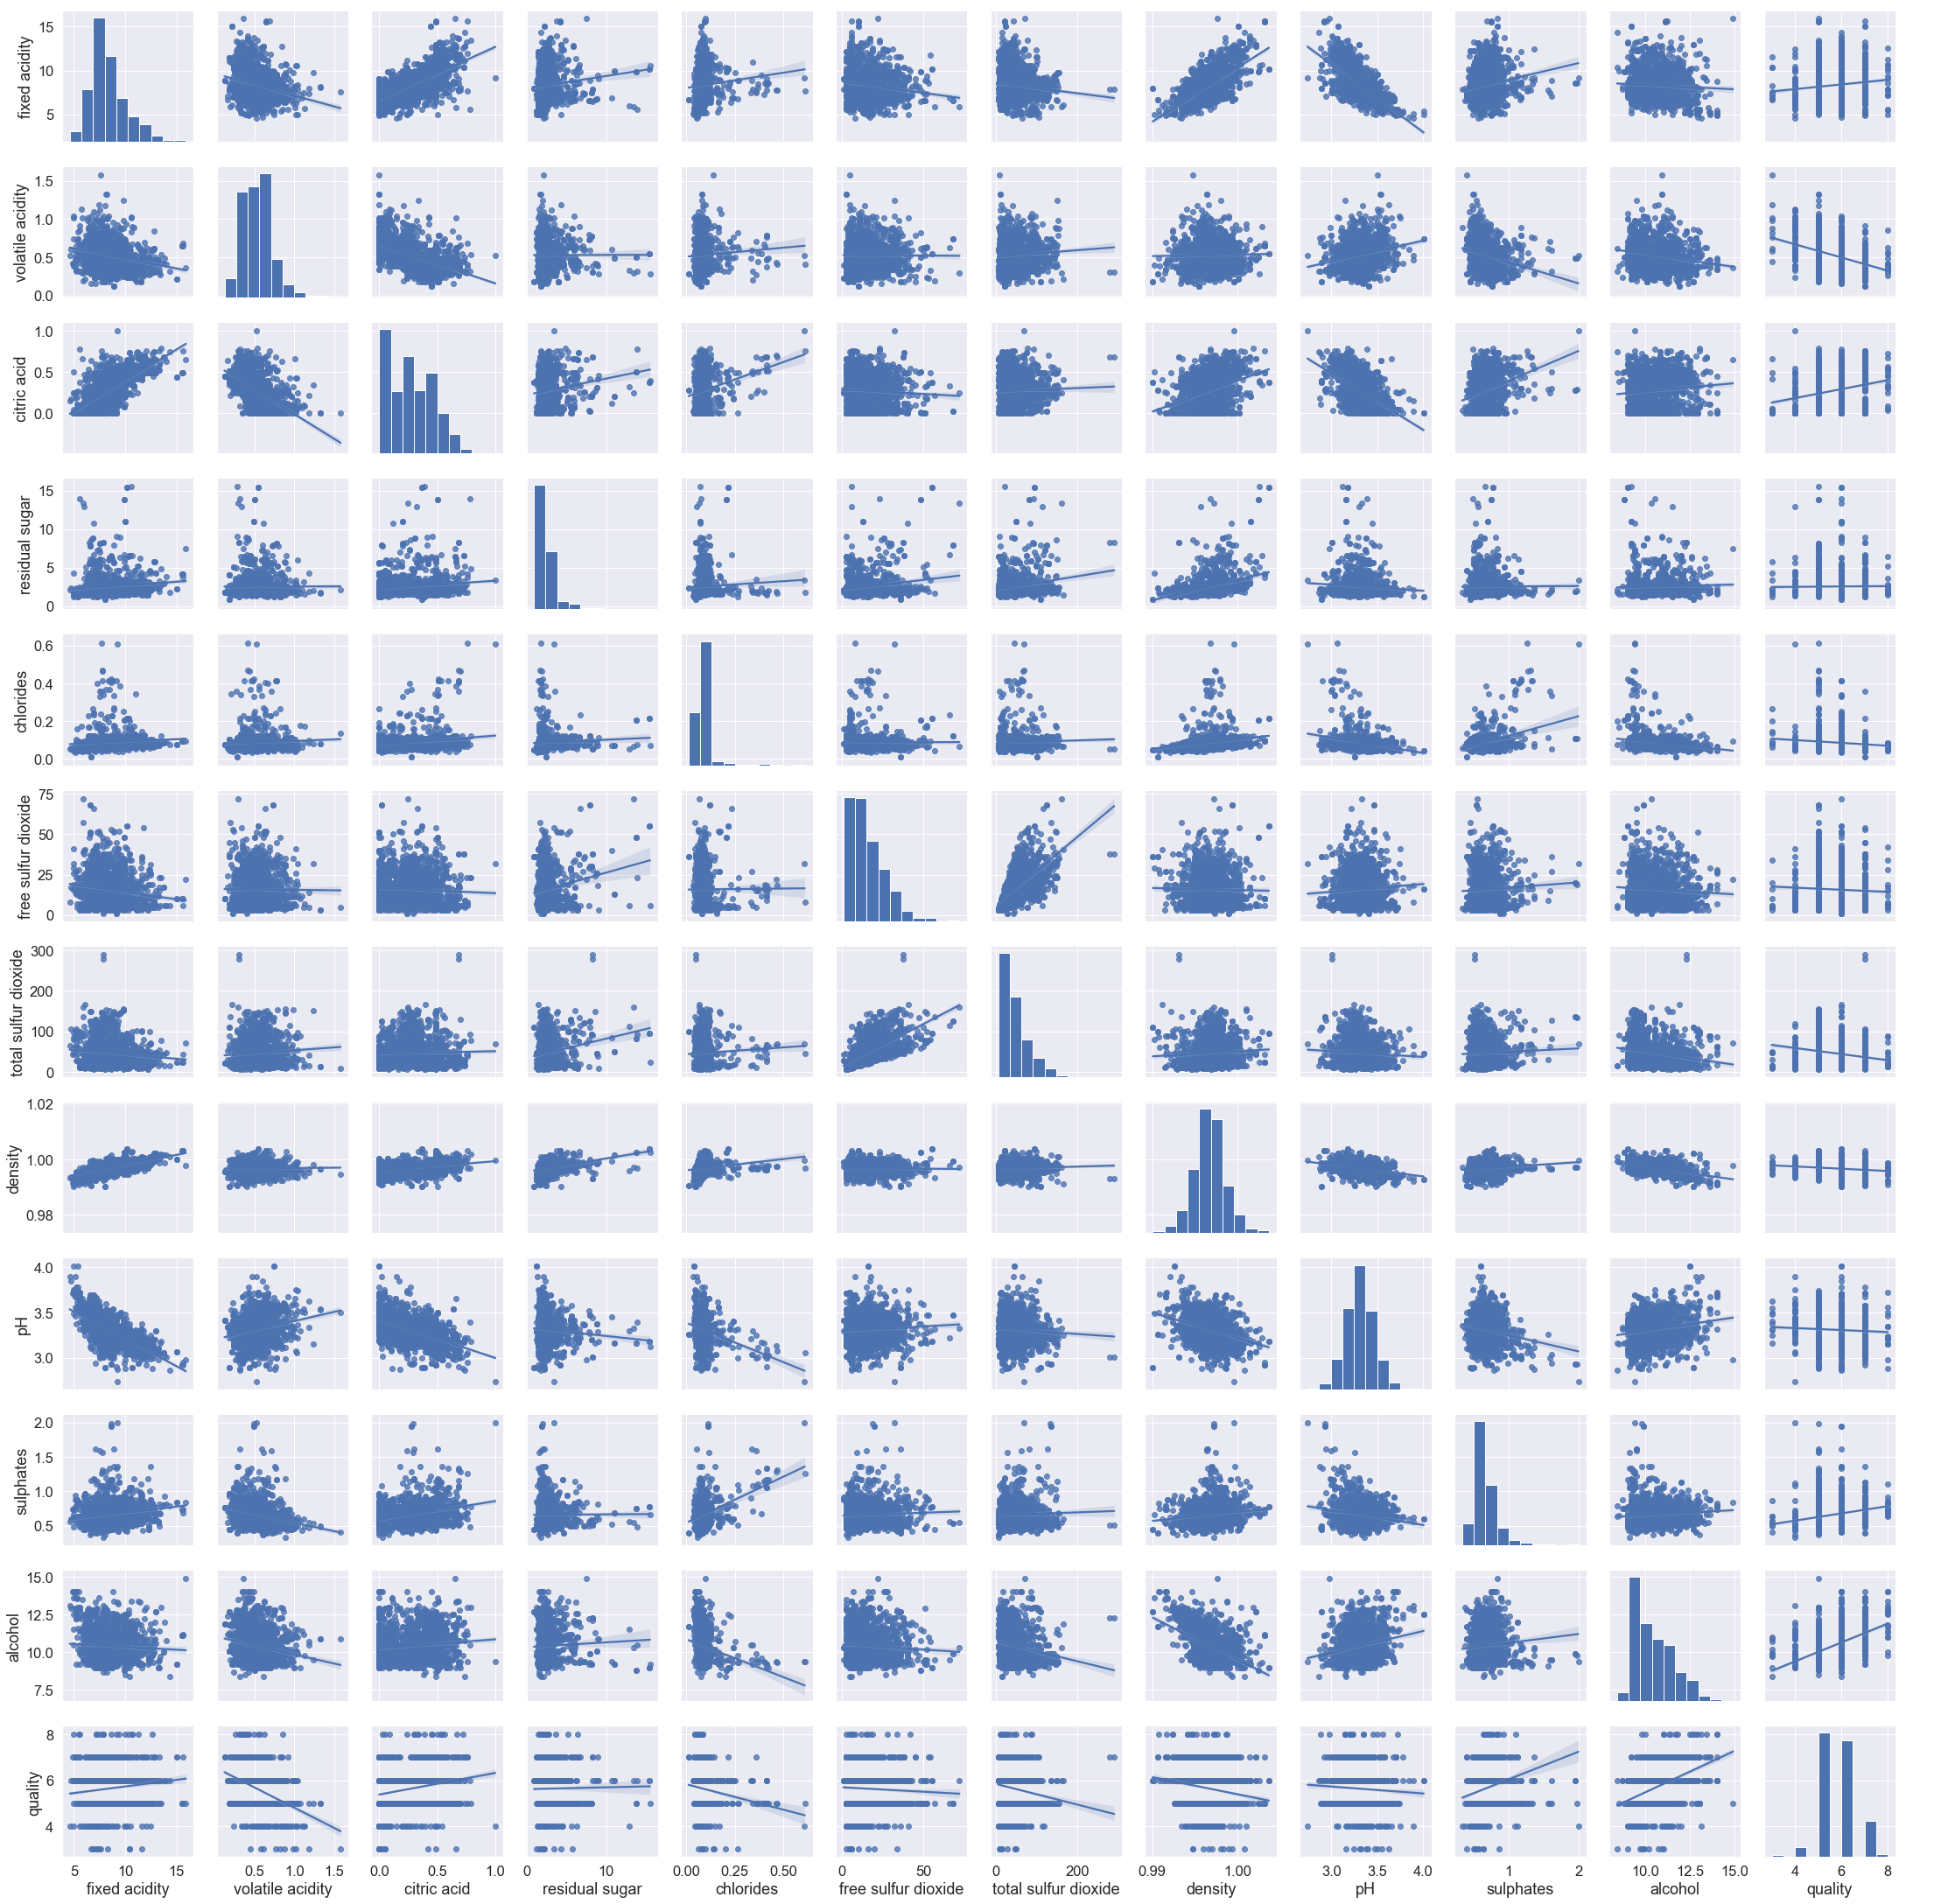

In [ ]:
plt.figure(figsize=(16, 16))
sns.set(font_scale=1.5)
sns.pairplot(wine_quality_df, kind="reg")

全部調べたいのはやまやまですが，特に，高い相関をもつ変数間を見ていく中で特徴量の不要・必要を考えます

In [ ]:
#　再度実行（check）
min_max_scaler = MinMaxScaler()
min_max_scaler.fit(X_train[feature_names])
X_train[feature_names] = min_max_scaler.transform(X_train[feature_names])
X_test[feature_names] = min_max_scaler.transform(X_test[feature_names])
cross_validation(linear_reg,False)
cross_validation(svm_reg, False)
cross_validation(svm_clf, False, method="clf")

Cross-Validation scores: [0.48785246 0.48902908 0.4327103  0.42970768 0.36331343]
Average score: 0.440522589529035
Train score in the case of quality 3: size 7, score 4.078043090023924
Train score in the case of quality 4: size 38, score 1.921787186805576
Train score in the case of quality 5: size 473, score 0.2728583383844099
Train score in the case of quality 6: size 434, score 0.2336422487186727
Train score in the case of quality 7: size 154, score 0.7356773706934017
Train score in the case of quality 8: size 13, score 2.4808925754363336
Cross-Validation scores: [0.48031325 0.51075555 0.43657073 0.44309081 0.37320645]
Average score: 0.4487873589460989
Train score in the case of quality 3: size 7, score 4.551261096025476
Train score in the case of quality 4: size 38, score 1.9254682130919063
Train score in the case of quality 5: size 473, score 0.22527608583499886
Train score in the case of quality 6: size 434, score 0.27599129667517297
Train score in the case of quality 7: size 154,

特徴量選択に戻ります．

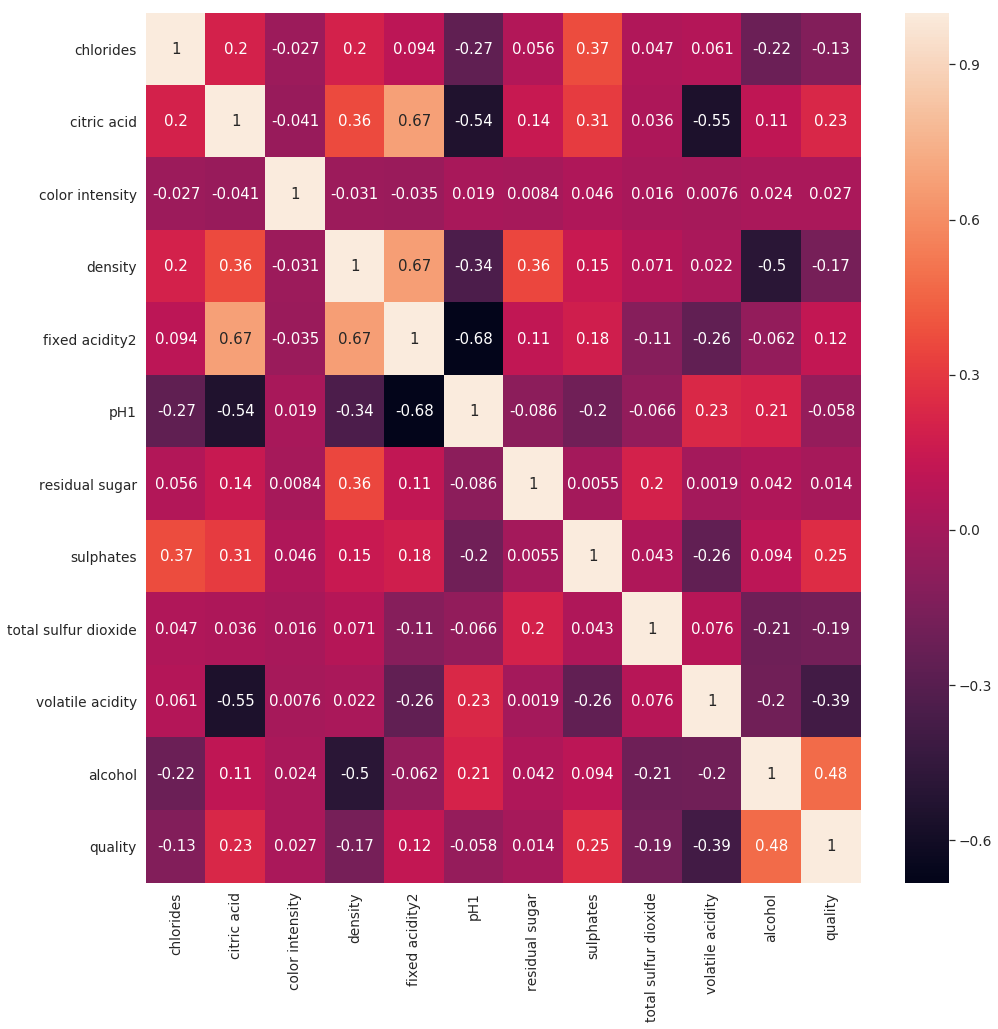

In [ ]:
plt.figure(figsize=(16, 16))
sns.set(font_scale=1.25)
sns.heatmap(wine_quality_df[feature_names+["quality"]].corr(), annot = True)

正直な所，alcohol と pH はここまで同じ意味をもっているとすると，どちらを選ぶかは容易でないです．
もっと言えば，ランダムに選択するしかないというのが現実かと思います．
ただ，これらの特徴を何らかの手法で片方ずつ弾けるかどうかは気になるところなので，後で確かめましょう．
ここでは後々の特徴量選択の効果がわからなくなるのを避けるため，alcohol2, pH2 を落とします．

In [ ]:
feature_names.remove("alcohol2")
feature_names.remove("pH2")
cross_validation(linear_reg, False)
cross_validation(svm_clf, False)
cross_validation(svm_reg, False)

Cross-Validation scores: [0.48893628 0.49018121 0.42632044 0.42753396 0.36348396]
Average score: 0.43929116969965065
Train score in the case of quality 3: size 7, score 4.0899672906687625
Train score in the case of quality 4: size 38, score 1.9247487260469693
Train score in the case of quality 5: size 473, score 0.27399220596290413
Train score in the case of quality 6: size 434, score 0.23163649409305448
Train score in the case of quality 7: size 154, score 0.7337749968678074
Train score in the case of quality 8: size 13, score 2.4946715430342126
Cross-Validation scores: [0.56696429 0.61160714 0.58035714 0.63839286 0.51121076]
Average score: 0.5817064381806535
Train score in the case of quality 3: size 7, score 4.714285714285714
Train score in the case of quality 4: size 38, score 1.5526315789473684
Train score in the case of quality 5: size 473, score 0.1649048625792812
Train score in the case of quality 6: size 434, score 0.46543778801843316
Train score in the case of quality 7: size

精度的にはガタっと落ちてしまいました（正直意外でしたが，同じ意味をもつ特徴量は要らないので削除方針のまま話を進めます）．
個別にその影響を一応確認しておきましょう．

In [ ]:
feature_names.append("pH2")
cross_validation(linear_reg, False)
cross_validation(svm_clf, False)
cross_validation(svm_reg, False)

Cross-Validation scores: [0.48894251 0.49010318 0.42609249 0.42744335 0.36413663]
Average score: 0.43934363211790883
Train score in the case of quality 3: size 7, score 4.082325469291342
Train score in the case of quality 4: size 38, score 1.922529087403842
Train score in the case of quality 5: size 473, score 0.2740680923361928
Train score in the case of quality 6: size 434, score 0.23176172045494248
Train score in the case of quality 7: size 154, score 0.7342165380588809
Train score in the case of quality 8: size 13, score 2.4907733495544466
Cross-Validation scores: [0.56696429 0.61607143 0.5625     0.66071429 0.52914798]
Average score: 0.5870795964125561
Train score in the case of quality 3: size 7, score 4.714285714285714
Train score in the case of quality 4: size 38, score 1.4736842105263157
Train score in the case of quality 5: size 473, score 0.16279069767441862
Train score in the case of quality 6: size 434, score 0.4792626728110599
Train score in the case of quality 7: size 15

In [ ]:
feature_names.append("alcohol2")
feature_names.remove("pH2")
cross_validation(linear_reg, False)
cross_validation(svm_clf, False)
cross_validation(svm_reg, False)

Cross-Validation scores: [0.48784962 0.48912368 0.43294872 0.4297815  0.36262444]
Average score: 0.4404655949832931
Train score in the case of quality 3: size 7, score 4.086054362659574
Train score in the case of quality 4: size 38, score 1.9241112965573586
Train score in the case of quality 5: size 473, score 0.2727810632726345
Train score in the case of quality 6: size 434, score 0.2334932534612903
Train score in the case of quality 7: size 154, score 0.7352031243521387
Train score in the case of quality 8: size 13, score 2.4850230592014615
Cross-Validation scores: [0.59375    0.60714286 0.58035714 0.625      0.49327354]
Average score: 0.5799047085201794
Train score in the case of quality 3: size 7, score 4.714285714285714
Train score in the case of quality 4: size 38, score 1.631578947368421
Train score in the case of quality 5: size 473, score 0.17970401691331925
Train score in the case of quality 6: size 434, score 0.4539170506912442
Train score in the case of quality 7: size 154,

In [ ]:
feature_names.remove("alcohol2")

精度面の分析では，単体では意味がないが，両方あると意味があるという感じでしょうか

上記のノイズの問題を置いておくと，まず気になるのは，sulfur dioxide の2つ，pH と酸性・アルカリ性の特徴量の関係です．

特に，sulfur dioxide は必要なのか？がまず気になります．

<Figure size 1152x1152 with 0 Axes>

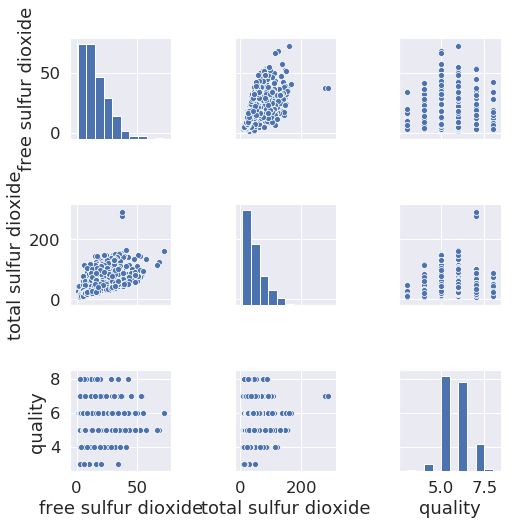

In [ ]:
plt.figure(figsize=(16, 16))
sns.set(font_scale=1.5)
sns.pairplot(wine_quality_df[['free sulfur dioxide', 'total sulfur dioxide', 'quality']])

In [ ]:
# 標準偏差等を出したが，あまりわからなかった
for i in np.sort(wine_quality_df["quality"].unique()):
    print(i,
          len(wine_quality_df[wine_quality_df["quality"]==i]["total sulfur dioxide"]),
          np.mean(wine_quality_df[wine_quality_df["quality"]==i]["total sulfur dioxide"]),
          np.std(wine_quality_df[wine_quality_df["quality"]==i]["total sulfur dioxide"]))

3 10 24.9 15.965274817553249
4 53 36.24528301886792 27.321914392150052
5 681 56.51395007342144 36.965944907826874
6 638 40.86990595611285 25.018620093878372
7 199 35.02010050251256 33.10770603628217
8 18 33.44444444444444 24.716666042306628


一応，何かしらの影響はあると思える．
硫酸について調べていると，酸化防止剤が良く出てきますが，二酸化硫黄（sulfur dioxide, SO2）と硫酸塩（sulphates, H2SO4）の違いについてもきになりました．
ただ，相関がみられないので両方落とすのはやめて，負の相関が大きい total sulfur dioxide を残しておきます．

In [ ]:
feature_names.remove("free sulfur dioxide")

In [ ]:
cross_validation(linear_reg, False)
cross_validation(svm_clf, False)
cross_validation(svm_reg, False)

Cross-Validation scores: [0.48660288 0.48645957 0.42527367 0.42695256 0.36367608]
Average score: 0.4377929546844209
Train score in the case of quality 3: size 7, score 4.0743623052111415
Train score in the case of quality 4: size 38, score 1.9245726701720784
Train score in the case of quality 5: size 473, score 0.2748002841372543
Train score in the case of quality 6: size 434, score 0.23136142440044352
Train score in the case of quality 7: size 154, score 0.7340102877511815
Train score in the case of quality 8: size 13, score 2.49830489974989
Cross-Validation scores: [0.55803571 0.59821429 0.56696429 0.63839286 0.50672646]
Average score: 0.5736667200512492
Train score in the case of quality 3: size 7, score 4.714285714285714
Train score in the case of quality 4: size 38, score 1.631578947368421
Train score in the case of quality 5: size 473, score 0.18181818181818182
Train score in the case of quality 6: size 434, score 0.44930875576036866
Train score in the case of quality 7: size 154

ほぼ同じ感じみたいです．

次に気になるのは，酸性を表す項目です．acidity, density, pH あたりでしょうか．特に fixed acidity2 はどうでしょう？

<Figure size 1152x1152 with 0 Axes>

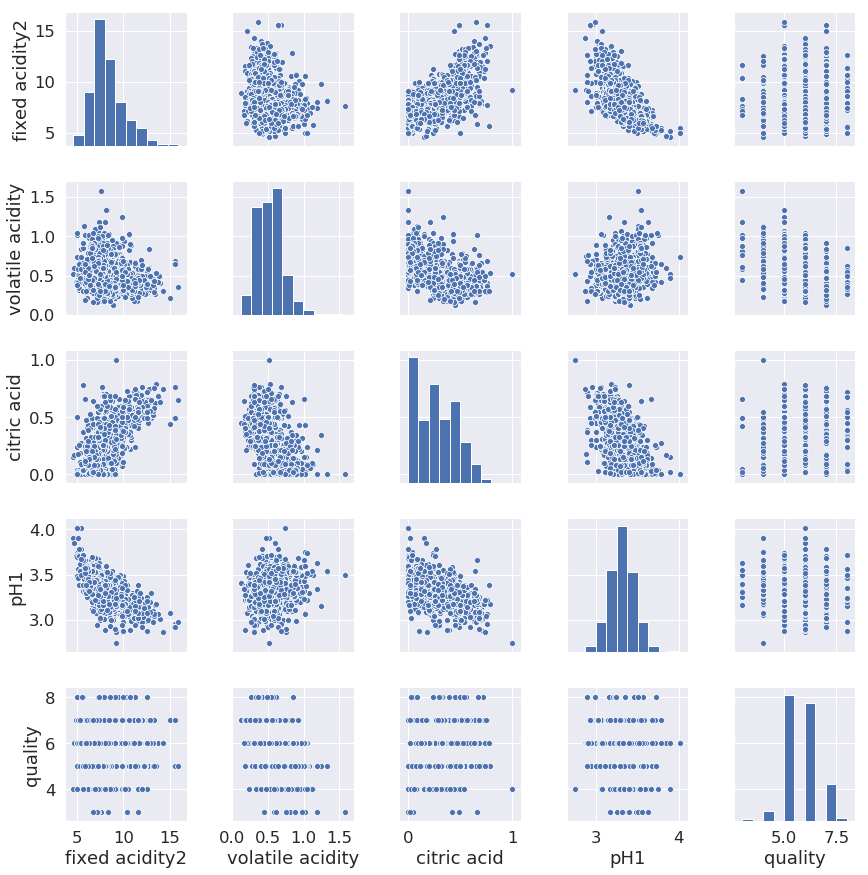

In [ ]:
plt.figure(figsize=(16, 16))
sns.set(font_scale=1.5)
sns.pairplot(wine_quality_df[['fixed acidity2', 'volatile acidity', 'citric acid', 'pH1', 'quality']])

'fixed acidity2' と 'pH1' がそれぞれ関連が強そうという印象を受けること，また，pH1とqualityの相関の低さから
今回は pH1 を削除することにしました．

'fixed acidity2' と 'volatile acidity' の関係は気になりますが今回はスルーすることにします．

In [ ]:
feature_names.remove("pH1")

In [ ]:
cross_validation(linear_reg, False)
cross_validation(svm_clf, False)
cross_validation(svm_reg, False)

Cross-Validation scores: [0.48642419 0.48832085 0.42778382 0.42856695 0.3576912 ]
Average score: 0.43775740389018747
Train score in the case of quality 3: size 7, score 4.180595484778517
Train score in the case of quality 4: size 38, score 1.9544831623645644
Train score in the case of quality 5: size 473, score 0.27436818703659266
Train score in the case of quality 6: size 434, score 0.23048259498506882
Train score in the case of quality 7: size 154, score 0.7286611143168502
Train score in the case of quality 8: size 13, score 2.5494039347366333
Cross-Validation scores: [0.55803571 0.59375    0.55357143 0.625      0.50224215]
Average score: 0.5665198590647023
Train score in the case of quality 3: size 7, score 4.714285714285714
Train score in the case of quality 4: size 38, score 1.631578947368421
Train score in the case of quality 5: size 473, score 0.1839323467230444
Train score in the case of quality 6: size 434, score 0.44930875576036866
Train score in the case of quality 7: size 1

ちょっと良くなったことがわかります．また，もっと早く対処しても良かったですが，color intensity はどの特徴に対しても無相関であまり意味のない特徴であると言えるため，削除します．

In [ ]:
feature_names.remove("color intensity")
cross_validation(linear_reg, False)
cross_validation(svm_clf, False)
cross_validation(svm_reg, False)

Cross-Validation scores: [0.4866928  0.48624987 0.42721936 0.42669237 0.35624042]
Average score: 0.43661896472615275
Train score in the case of quality 3: size 7, score 4.187090980937549
Train score in the case of quality 4: size 38, score 1.9568498458118426
Train score in the case of quality 5: size 473, score 0.27427247607081107
Train score in the case of quality 6: size 434, score 0.2296360666637838
Train score in the case of quality 7: size 154, score 0.7298554120077114
Train score in the case of quality 8: size 13, score 2.5705018532198816
Cross-Validation scores: [0.54910714 0.59821429 0.55803571 0.59375    0.48878924]
Average score: 0.5575792761050609
Train score in the case of quality 3: size 7, score 4.714285714285714
Train score in the case of quality 4: size 38, score 1.631578947368421
Train score in the case of quality 5: size 473, score 0.19238900634249473
Train score in the case of quality 6: size 434, score 0.43548387096774194
Train score in the case of quality 7: size 1

結果としては，あまりにも相関の強い特徴量がある時よりは低くなっているのが現状です．

もう一度データを見直して対策を考えます．

In [ ]:
wine_quality_df[feature_names].describe()

,chlorides,citric acid,density,fixed acidity2,residual sugar,sulphates,total sulfur dioxide,volatile acidity,alcohol
count,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000
mean,0.087467,0.270976,0.996747,8.319637,2.538806,0.658149,46.467792,0.527821,10.422983
std,0.047065,0.194801,0.001887,1.741096,1.409928,0.169507,32.895324,0.179060,1.065668
min,0.012000,0.000000,0.990070,4.600000,0.900000,0.330000,6.000000,0.120000,8.400000
25%,0.070000,0.090000,0.995600,7.100000,1.900000,0.550000,22.000000,0.390000,9.500000
50%,0.079000,0.260000,0.996750,7.900000,2.200000,0.620000,38.000000,0.520000,10.200000
75%,0.090000,0.420000,0.997835,9.200000,2.600000,0.730000,62.000000,0.640000,11.100000
max,0.611000,1.000000,1.003690,15.900000,15.500000,2.000000,289.000000,1.580000,14.900000


外れ値除去もしてみましょう．sklearn に outlier factor というのがあるんですが簡単には使えなさそうだったので

total sulfur dioxide と residual sugar は流石に外れ値では？と思えるような最大値があるようなので，それらを取り除くために平均＋標準偏差＊2くらいの範囲を使ってみることにします（決め打ちです）．

In [ ]:
def outlier_remove(origin, target):
    m, s = np.mean(origin), np.std(origin)
    new_origin_values = np.min([origin, np.ones_like(origin)*m+s*2], axis=0)
    new_origin_values = np.max([new_origin_values, np.ones_like(origin)*m-s*2], axis=0) 
    new_target_values = np.min([target, np.ones_like(target)*m+s*2], axis=0)
    new_target_values = np.max([new_target_values, np.ones_like(target)*m-s*2], axis=0) 
    return new_origin_values, new_target_values

In [ ]:
X_train["total sulfur dioxide"], X_test["total sulfur dioxide"] = \
    outlier_remove(X_train["total sulfur dioxide"].values, X_test["total sulfur dioxide"].values)

In [ ]:
cross_validation(linear_reg, False)
cross_validation(svm_clf, False)
cross_validation(svm_reg, False)

Cross-Validation scores: [0.48575845 0.48396737 0.42473252 0.42800748 0.35621797]
Average score: 0.43573675952831376
Train score in the case of quality 3: size 7, score 4.216293979568908
Train score in the case of quality 4: size 38, score 1.9611023601210724
Train score in the case of quality 5: size 473, score 0.27371390680148516
Train score in the case of quality 6: size 434, score 0.22968077119790364
Train score in the case of quality 7: size 154, score 0.7230221340689679
Train score in the case of quality 8: size 13, score 2.5772751767809887
Cross-Validation scores: [0.55357143 0.59375    0.54910714 0.59821429 0.49775785]
Average score: 0.5584801409352979
Train score in the case of quality 3: size 7, score 4.714285714285714
Train score in the case of quality 4: size 38, score 1.631578947368421
Train score in the case of quality 5: size 473, score 0.18816067653276955
Train score in the case of quality 6: size 434, score 0.4400921658986175
Train score in the case of quality 7: size 1

In [ ]:
X_train["residual sugar"], X_test["residual sugar"] = \
    outlier_remove(X_train["residual sugar"].values, X_test["residual sugar"].values)
cross_validation(linear_reg, False)
cross_validation(svm_clf, False)
cross_validation(svm_reg, False)

Cross-Validation scores: [0.48608365 0.48259606 0.42622677 0.4356865  0.35981808]
Average score: 0.43808221193899016
Train score in the case of quality 3: size 7, score 4.216364931220535
Train score in the case of quality 4: size 38, score 1.9525770978253278
Train score in the case of quality 5: size 473, score 0.27450287374186855
Train score in the case of quality 6: size 434, score 0.23090863830931088
Train score in the case of quality 7: size 154, score 0.7266801901939304
Train score in the case of quality 8: size 13, score 2.582928684999428
Cross-Validation scores: [0.54910714 0.58482143 0.54017857 0.62053571 0.49327354]
Average score: 0.5575832799487508
Train score in the case of quality 3: size 7, score 4.714285714285714
Train score in the case of quality 4: size 38, score 1.631578947368421
Train score in the case of quality 5: size 473, score 0.18816067653276955
Train score in the case of quality 6: size 434, score 0.43317972350230416
Train score in the case of quality 7: size 1

# 正直，良くはなってませんが，人間の限界という気がするので，本番ということにします

In [ ]:
cross_validation(linear_reg, True)
cross_validation(svm_reg, True)
cross_validation(svm_clf, True, method="clf")

Cross-Validation scores: [0.48608365 0.48259606 0.42622677 0.4356865  0.35981808]
Average score: 0.43808221193899016
Train score in the case of quality 3: size 7, score 4.216364931220535
Train score in the case of quality 4: size 38, score 1.9525770978253278
Train score in the case of quality 5: size 473, score 0.27450287374186855
Train score in the case of quality 6: size 434, score 0.23090863830931088
Train score in the case of quality 7: size 154, score 0.7266801901939304
Train score in the case of quality 8: size 13, score 2.582928684999428
Test score: 0.4031141917416317
Test score in the case of quality 3: size 3, score 3.0
Test score in the case of quality 4: size 15, score 1.2666666666666666
Test score in the case of quality 5: size 208, score 0.125
Test score in the case of quality 6: size 204, score 0.6519607843137255
Test score in the case of quality 7: size 45, score 1.9333333333333333
Test score in the case of quality 8: size 5, score 5.0
Cross-Validation scores: [0.4791630

# 元の特徴量を使った時の予測結果

In [ ]:
origin_features = ['fixed acidity2', 'volatile acidity', 'citric acid', 'residual sugar',
       'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
       'pH1', 'sulphates', 'alcohol']
tmp = np.copy(feature_names)
feature_names = origin_features

In [ ]:
cross_validation(linear_reg, True)
cross_validation(svm_reg, True)
cross_validation(svm_clf, True, method="clf")

Cross-Validation scores: [0.48576723 0.48438713 0.42398534 0.43498084 0.36344055]
Average score: 0.43851221691391684
Train score in the case of quality 3: size 7, score 4.133144210596645
Train score in the case of quality 4: size 38, score 1.9182805776250749
Train score in the case of quality 5: size 473, score 0.2731151693664415
Train score in the case of quality 6: size 434, score 0.23196904095321202
Train score in the case of quality 7: size 154, score 0.7307259074136737
Train score in the case of quality 8: size 13, score 2.5219220451135835
Test score: 0.4000250989250356
Test score in the case of quality 3: size 3, score 3.0
Test score in the case of quality 4: size 15, score 1.2666666666666666
Test score in the case of quality 5: size 208, score 0.12980769230769232
Test score in the case of quality 6: size 204, score 0.6666666666666666
Test score in the case of quality 7: size 45, score 1.8
Test score in the case of quality 8: size 5, score 5.0
Cross-Validation scores: [0.47500136

一応，元の特徴量を用いた時と同じ精度を達成することができたので，良しとします．

ただ，元の特徴量からの特徴量選択した結果としては，元の特徴量全てを用いた時の結果の方がわずかにいいという
少々残念な結果になりました．

# これで終わると，えーと言われそうなので．
一応，変数を順に増加させていくシナリオも見ておきました．全探索もできると思いますが

参考：https://qiita.com/shimopino/items/5fee7504c7acf044a521

In [ ]:
def cross_validation_check(model, features, test=True):
    global X_train, X_test, y_train, y_test
    scores = cross_val_score(model, X_train[features], y_train, cv=kfold, 
                             scoring=make_scorer(mean_squared_error))
    return np.mean(scores)

In [ ]:
feature_names = list(np.copy(wine_quality_df.columns))
feature_names.remove("quality")
select_info = []
select_names = []
while len(feature_names) != 0:
    max_feature = ""
    min_score = 1
    for feature in feature_names:
        score = cross_validation_check(svm_reg, select_names+[feature], True)
        if min_score > score:
            max_feature = feature
            min_score = score
    feature_names.remove(max_feature)
    select_names.append(max_feature)
    select_info.append([list(select_names), min_score])
select_info

[[['alcohol'], 0.5511417825418977],
 [['alcohol', 'volatile acidity'], 0.46619492955759834],
 [['alcohol', 'volatile acidity', 'sulphates'], 0.4461228221596327],
 [['alcohol', 'volatile acidity', 'sulphates', 'total sulfur dioxide'],
  0.43745946830237425],
 [['alcohol',
   'volatile acidity',
   'sulphates',
   'total sulfur dioxide',
   'chlorides'],
  0.434622533967723],
 [['alcohol',
   'volatile acidity',
   'sulphates',
   'total sulfur dioxide',
   'chlorides',
   'pH1'],
  0.43288666823946753],
 [['alcohol',
   'volatile acidity',
   'sulphates',
   'total sulfur dioxide',
   'chlorides',
   'pH1',
   'pH2'],
  0.4334864713326415],
 [['alcohol',
   'volatile acidity',
   'sulphates',
   'total sulfur dioxide',
   'chlorides',
   'pH1',
   'pH2',
   'free sulfur dioxide'],
  0.4344252782594286],
 [['alcohol',
   'volatile acidity',
   'sulphates',
   'total sulfur dioxide',
   'chlorides',
   'pH1',
   'pH2',
   'free sulfur dioxide',
   'density'],
  0.4360294841108609],
 [['al

結果としては，下記の物が一番良さそうなのでテストしてみます．
[['alcohol',
   'volatile acidity',
   'sulphates',
   'total sulfur dioxide',
   'chlorides',
   'pH1'],
  0.43288666823946753],

In [ ]:
feature_names =  ['alcohol', 'volatile acidity', 'sulphates', 'total sulfur dioxide', 'chlorides', 'pH1']
cross_validation(linear_reg, True)
cross_validation(svm_reg, True)
cross_validation(svm_clf, True, method="clf")

Cross-Validation scores: [0.47965087 0.47462526 0.41909166 0.42775314 0.36455096]
Average score: 0.4331343788890917
Train score in the case of quality 3: size 7, score 4.063220220393757
Train score in the case of quality 4: size 38, score 1.9026100733675577
Train score in the case of quality 5: size 473, score 0.27504419012638925
Train score in the case of quality 6: size 434, score 0.23154159280173944
Train score in the case of quality 7: size 154, score 0.7389550097759864
Train score in the case of quality 8: size 13, score 2.5065247648742424
Test score: 0.4035773866093709
Test score in the case of quality 3: size 3, score 3.0
Test score in the case of quality 4: size 15, score 1.2666666666666666
Test score in the case of quality 5: size 208, score 0.12980769230769232
Test score in the case of quality 6: size 204, score 0.6617647058823529
Test score in the case of quality 7: size 45, score 1.8
Test score in the case of quality 8: size 5, score 5.0
Cross-Validation scores: [0.47623616

結果としても良くなっています．また，何よりも嬉しかったのはノイズとなる特徴量をちゃんと全部はじけてたことでした．

In [ ]:
# 一応，全部テスト
for feature_names, cv_score in select_info:
    print(feature_names)
    #cross_validation(svm_clf, True)
    cross_validation(svm_reg, True)
    print("\n")

['alcohol']
Cross-Validation scores: [0.607749   0.6161667  0.49978001 0.54519663 0.48681657]
Average score: 0.5511417825418977
Train score in the case of quality 3: size 7, score 6.362501982654973
Train score in the case of quality 4: size 38, score 2.3997123639639106
Train score in the case of quality 5: size 473, score 0.2202830685535958
Train score in the case of quality 6: size 434, score 0.34930007986936934
Train score in the case of quality 7: size 154, score 1.151454696020937
Train score in the case of quality 8: size 13, score 3.203280426899968
Test score: 0.4351048724290692
Test score in the case of quality 3: size 3, score 2.0
Test score in the case of quality 4: size 15, score 1.6666666666666667
Test score in the case of quality 5: size 208, score 0.08653846153846154
Test score in the case of quality 6: size 204, score 0.7892156862745098
Test score in the case of quality 7: size 45, score 2.2
Test score in the case of quality 8: size 5, score 5.0


['alcohol', 'volatile aci

Cross-Validation scores: [0.47565781 0.48724768 0.4159349  0.43512407 0.36618296]
Average score: 0.4360294841108609
Train score in the case of quality 3: size 7, score 4.417255904655826
Train score in the case of quality 4: size 38, score 1.8775804300250032
Train score in the case of quality 5: size 473, score 0.22802286312334655
Train score in the case of quality 6: size 434, score 0.2509232040862004
Train score in the case of quality 7: size 154, score 0.8190015511185466
Train score in the case of quality 8: size 13, score 2.6393082103940086
Test score: 0.39023471630715567
Test score in the case of quality 3: size 3, score 3.0
Test score in the case of quality 4: size 15, score 1.2
Test score in the case of quality 5: size 208, score 0.12980769230769232
Test score in the case of quality 6: size 204, score 0.7058823529411765
Test score in the case of quality 7: size 45, score 1.8666666666666667
Test score in the case of quality 8: size 5, score 5.0


['alcohol', 'volatile acidity', 's

全部に対する結果を確認してみると，CVのスコアとテストのスコアがほぼ連動しています．
今回扱ったデータ（あるいは分割された train と test 間）はほとんど同じデータだったと言えます．

※現実では全然違うことがあるので注意．

# 結論・考察
元の特徴量を使った時の精度が元々高かったため，

一方で，特徴量の排除というのは必ずしも必要とはいえないという結果になりました．